# Auto reload modules

In [1]:
%load_ext autoreload
%autoreload 2

# Directories

In [3]:
import fs
import os

In [3]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "../../spark-3.5.3-bin-hadoop3"

In [4]:
import findspark
findspark.init()

In [5]:
import pyspark
from pyspark.sql import functions as F
from pyspark.sql import SparkSession

In [6]:
spark = (SparkSession.builder
  .master('local[*]')
  .appName('hello_world_spark')
  .getOrCreate())

cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("You are working with", cores, "core(s)")
spark

24/11/21 18:11:48 WARN Utils: Your hostname, ThinkPad-X1-Nano resolves to a loopback address: 127.0.1.1; using 192.168.68.130 instead (on interface wlp0s20f3)
24/11/21 18:11:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/21 18:11:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


You are working with 1 core(s)


In [7]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [4]:
RAW_DIR = fs.open_fs("../../data/raw")
CSV_DIR = RAW_DIR.getsyspath("checkouts-by-title.csv")

In [9]:
filePath = CSV_DIR

rawDF = spark.read.csv(filePath,
                       header="true",
                       inferSchema="true",
                       multiLine="true",
                       escape='"')

rawDF.show(3, truncate=False)

+----------+------------+------------+------------+-------------+---------+------------------------------------------------------------------------------------------+------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------+---------------+
|UsageClass|CheckoutType|MaterialType|CheckoutYear|CheckoutMonth|Checkouts|Title                                                                                     |Creator           |Subjects                                                                                                                                                         |Publisher                           |PublicationYear|
+----------+------------+------------+------------+-------------+---------+------------------------------------------------------------------------------------------+------------------+-------------

In [10]:
rawDF.printSchema()

root
 |-- UsageClass: string (nullable = true)
 |-- CheckoutType: string (nullable = true)
 |-- MaterialType: string (nullable = true)
 |-- CheckoutYear: integer (nullable = true)
 |-- CheckoutMonth: integer (nullable = true)
 |-- Checkouts: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Creator: string (nullable = true)
 |-- Subjects: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- PublicationYear: string (nullable = true)



In [11]:
rawDF.summary().show()

24/11/21 16:28:15 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+----------+------------+------------+------------------+------------------+-----------------+----------------------------------------+----------------------+--------------------+--------------------+------------------+
|summary|UsageClass|CheckoutType|MaterialType|      CheckoutYear|     CheckoutMonth|        Checkouts|                                   Title|               Creator|            Subjects|           Publisher|   PublicationYear|
+-------+----------+------------+------------+------------------+------------------+-----------------+----------------------------------------+----------------------+--------------------+--------------------+------------------+
|  count|  34892623|    34892623|    34892623|          34892623|          34892623|         34892623|                                34892623|              22690892|            33163784|            25314018|          24999120|
|   mean|      NULL|        NULL|        NULL|2012.5187779090154| 6.437536151982613|3.51

# Nueva estrategia leyendo con Sample reservoir

In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id
import random
import time

In [10]:
n_sample = 500_000  # Tamaño del reservoir

start_time = time.time()

# Carga el archivo CSV como un RDD
data_rdd = spark.read.csv(CSV_DIR, header=True).rdd

# Tamaño de la muestra por partición simulada
# Aquí simulamos leer "chunks" al dividir el archivo en múltiples particiones
n_rows_read = 100_000

# Divide el archivo en particiones para simular el comportamiento de lectura por chunks
partitioned_rdd = data_rdd.repartition(data_rdd.count() // n_rows_read + 1)


In [11]:
# Función de Reservoir Sampling para una partición
def reservoir_sampling_partition(iterator, reservoir_size, current_count):
    reservoir = []
    for idx, row in enumerate(iterator):
        if len(reservoir) < reservoir_size:
            reservoir.append(row)
        else:
            j = random.randrange(current_count + idx + 1)
            if j < reservoir_size:
                reservoir[j] = row
    return iter(reservoir)

In [ ]:
# Aplica el Reservoir Sampling a cada partición, manteniendo la cuenta total
reservoir = []
current_count = 0

for partition in partitioned_rdd.toLocalIterator():
    partition_reservoir = list(reservoir_sampling_partition(partition, n_sample, current_count))
    current_count += len(partition)
    # Combina el reservoir globalmente
    for i in range(len(partition_reservoir)):
        j = random.randrange(current_count)
        if j < n_sample:
            if len(reservoir) < n_sample:
                reservoir.append(partition_reservoir[i])
            else:
                reservoir[j] = partition_reservoir[i]

In [14]:
# Cargar el esquema del CSV
schema = spark.read.csv(CSV_DIR, header=True).schema

# Convertir los objetos del reservoir a listas para que coincidan con el esquema
reservoir_as_list = [tuple(row) for row in reservoir]

# Crear el DataFrame usando el esquema correcto
sampled_df = spark.createDataFrame(reservoir_as_list, schema=schema)

TypeError: 'NoneType' object is not iterable

In [ ]:
# Resultados
sampled_df.show(truncate=False)
print(f"--- {time.time() - start_time} seconds ---")
print(f"Total Sampled Rows: {sampled_df.count()}")

# Realizado en python

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
df_total = pd.read_csv(CSV_DIR)

In [ ]:
n_rows_read = 50000
stop = 175
#--inicializamos el manejar de lectura
reader = pd.read_csv(CSV_DIR, chunksize = n_rows_read)
#--iteramos hasta llegar al final del archivo
df = pd.DataFrame()

for index,rows in enumerate(reader):
    df = df.append(rows)
    
    if index % 50 == 0:
        print(index)
    if index >= stop:
        break
        
df

0
50
100
150


,UsageClass,CheckoutType,MaterialType,CheckoutYear,CheckoutMonth,Checkouts,Title,Creator,Subjects,Publisher,PublicationYear
0,Physical,Horizon,BOOK,2006,6,1,McGraw-Hill's dictionary of American slang and...,"Spears, Richard A.",English language United States Slang Dictionar...,"McGraw-Hill,",c2006.
1,Physical,Horizon,BOOK,2006,6,1,"Emma, Lady Hamilton / Flora Fraser.","Fraser, Flora","Hamilton Emma Lady 1761 1815, Nelson Horatio N...","Knopf : Distributed by Random House,","1987, c1986."
2,Physical,Horizon,BOOK,2006,6,2,Red midnight,NaN,"Survival Fiction, Emigration and immigration F...",NaN,NaN
3,Physical,Horizon,BOOK,2006,6,1,Just the financial facts how to identify nugge...,NaN,Investments Information services,NaN,NaN
4,Physical,Horizon,SOUNDCASS,2006,6,3,single shard,NaN,"Korea Fiction, Pottery Fiction",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
8799995,Physical,Horizon,BOOK,2010,8,2,Perennial companions : 100 dazzling plant comb...,"Fischer, Thomas, 1955-",Perennials,"Timber Press,",2009.
8799996,Physical,Horizon,BOOK,2010,8,1,American writers at home / J.D. McClatchy ; ph...,"McClatchy, J. D., 1945-","Literary landmarks United States, Authors Amer...",Library of America in association with Vendome...,c2004.
8799997,Physical,Horizon,BOOK,2010,8,1,Introduction to the comparative grammar of Gre...,"King, J. E. (John Edward), 1858-1939","Greek language Grammar Comparative Latin, Lati...","Clarendon Press,",1890.
8799998,Physical,Horizon,CR,2010,8,5,Rome.,NaN,Rome Italy Guidebooks,"Lonely Planet Publications,",1999-


In [ ]:
df_total.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34892623 entries, 0 to 34892622
Data columns (total 11 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   UsageClass       object
 1   CheckoutType     object
 2   MaterialType     object
 3   CheckoutYear     int64 
 4   CheckoutMonth    int64 
 5   Checkouts        int64 
 6   Title            object
 7   Creator          object
 8   Subjects         object
 9   Publisher        object
 10  PublicationYear  object
dtypes: int64(3), object(8)
memory usage: 21.3 GB


In [ ]:
df_total.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34892623 entries, 0 to 34892622
Data columns (total 11 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   UsageClass       object
 1   CheckoutType     object
 2   MaterialType     object
 3   CheckoutYear     int64 
 4   CheckoutMonth    int64 
 5   Checkouts        int64 
 6   Title            object
 7   Creator          object
 8   Subjects         object
 9   Publisher        object
 10  PublicationYear  object
dtypes: int64(3), object(8)
memory usage: 21.3 GB


In [ ]:
df_total.describe()

,CheckoutYear,CheckoutMonth,Checkouts
count,3.489262e+07,3.489262e+07,3.489262e+07
mean,2.012519e+03,6.437536e+00,3.519500e+00
std,4.140205e+00,3.408022e+00,8.499515e+00
min,2.005000e+03,1.000000e+00,1.000000e+00
25%,2.009000e+03,4.000000e+00,1.000000e+00
50%,2.013000e+03,6.000000e+00,2.000000e+00
75%,2.016000e+03,9.000000e+00,3.000000e+00
max,2.019000e+03,1.200000e+01,1.830000e+03


In [ ]:
for column in df_total.columns:
    print(column,df_total[column].isna().sum())

UsageClass 0
CheckoutType 0
MaterialType 0
CheckoutYear 0
CheckoutMonth 0
Checkouts 0
Title 0
Creator 12201731
Subjects 1728873
Publisher 9578605
PublicationYear 9893503


In [ ]:
for column in df_total.columns:
    print(column,len(df_total[column].unique()),"\n")

UsageClass 2 

CheckoutType 5 

MaterialType 65 

CheckoutYear 15 

CheckoutMonth 12 

Checkouts 651 

Title 1452093 

Creator 336269 

Subjects 777538 

Publisher 80995 

PublicationYear 12315 



In [ ]:
df_group = df_total.groupby(['CheckoutYear']).count().reset_index().sort_values('CheckoutYear', ascending=True)[["CheckoutYear","UsageClass"]]
df_group.columns = ['CheckoutYear', 'Count']
df_group

,CheckoutYear,Count
0,2005,1202919
1,2006,2185156
2,2007,2049529
3,2008,2138409
4,2009,2177311
5,2010,2251022
6,2011,2399519
7,2012,2219446
8,2013,2616135
9,2014,2724168


Text(0, 0.5, 'No. Ventas')

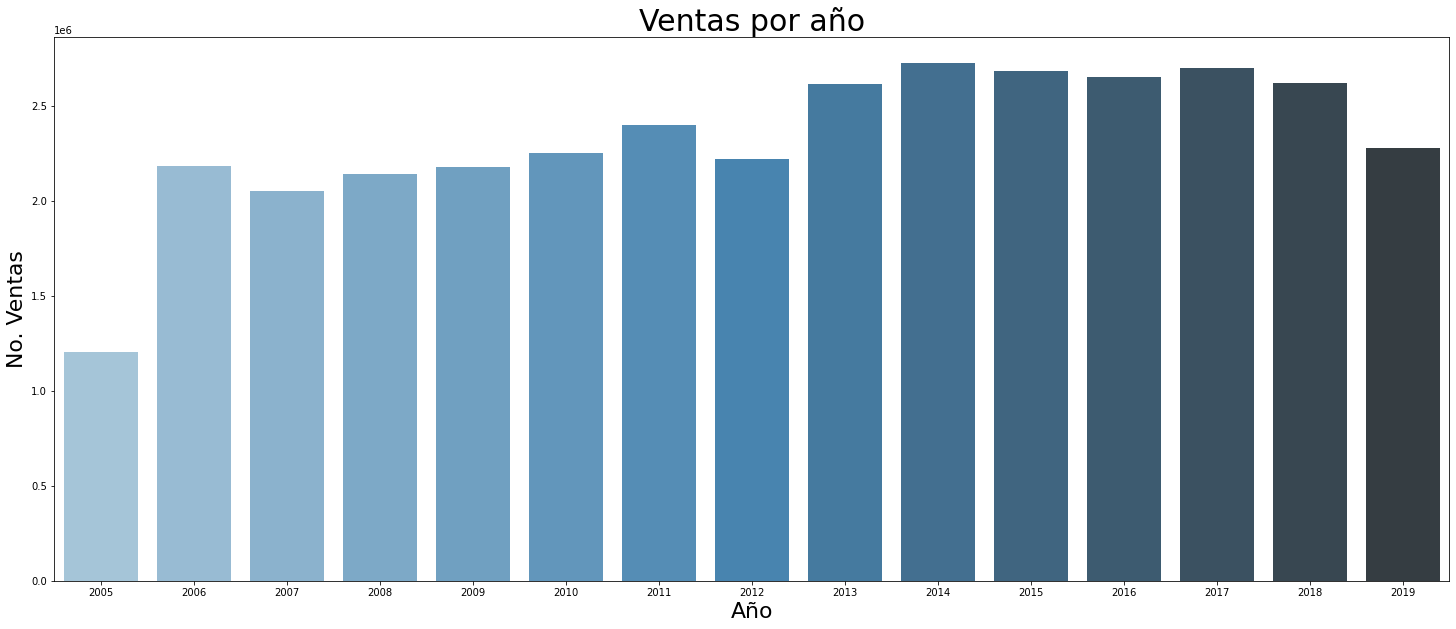

In [ ]:
plt.figure(figsize = (25, 10))
ax = sns.barplot(x="CheckoutYear", y="Count", data=df_group, palette="Blues_d")
plt.title("Ventas por año", fontsize=30)
ax.set_xlabel('Año', fontsize=22)
ax.set_ylabel('No. Ventas', fontsize=22)

Text(0, 0.5, 'No. Ventas')

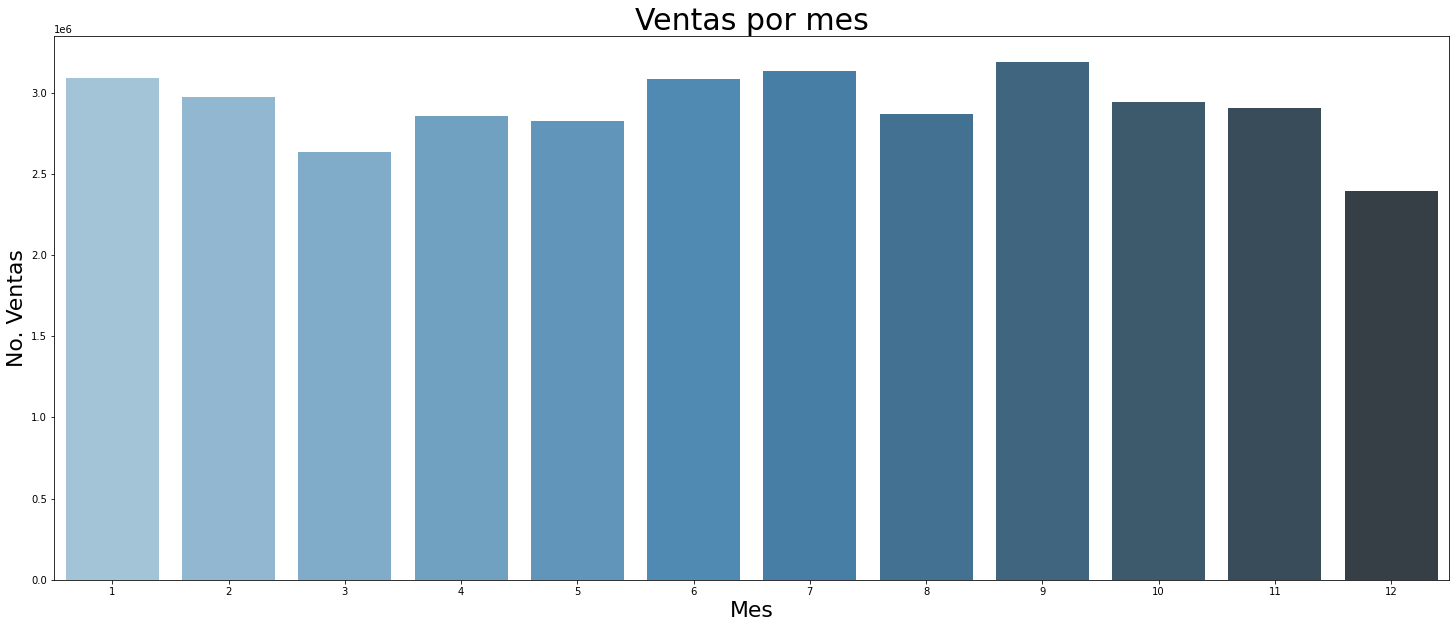

In [ ]:
df_group = df_total.groupby(['CheckoutMonth']).count().reset_index().sort_values('CheckoutMonth', ascending=True)[["CheckoutMonth","UsageClass"]]
df_group.columns = ['CheckoutMonth', 'Count']
df_group

plt.figure(figsize = (25, 10))
ax = sns.barplot(x="CheckoutMonth", y="Count", data=df_group, palette="Blues_d")
plt.title("Ventas por mes", fontsize=30)
ax.set_xlabel('Mes', fontsize=22)
ax.set_ylabel('No. Ventas', fontsize=22)

In [ ]:
df_group = df_total.groupby('UsageClass').count()['CheckoutMonth'].reset_index()
total = sum(df_group['CheckoutMonth'])
columns = ['UsageClass', 'count']
df_group.columns = columns
df_group = df_group.assign(distribution = df_group['count'].apply(lambda x: x * 100 / total))
df_group

,UsageClass,count,distribution
0,Digital,7065798,20.25012
1,Physical,27826825,79.74988


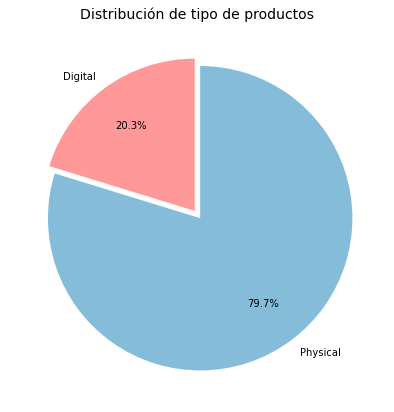

In [ ]:
pie, ax = plt.subplots(figsize=[10,7])
colors = ['#ff9999', '#84BCDA','#99ff99','#ffcc99', "#c2c2f0"]
plt.pie(x=df_group['distribution'], autopct="%.1f%%", explode=[0.03]*2, startangle=90, labels=df_group['UsageClass'], pctdistance=0.7, colors=colors)
plt.title("Distribución de tipo de productos", fontsize=14);

In [ ]:
df_group = df_total.groupby('CheckoutType').count()['CheckoutMonth'].reset_index()
total = sum(df_group['CheckoutMonth'])
columns = ['CheckoutType', 'count']
df_group.columns = columns
df_group = df_group.assign(distribution = df_group['count'].apply(lambda x: x * 100 / total))
df_group

,CheckoutType,count,distribution
0,Freegal,958361,2.746601
1,Hoopla,285925,0.819443
2,Horizon,27826825,79.749880
3,OverDrive,5812427,16.658040
4,Zinio,9085,0.026037


In [ ]:
import json
dict_ = """
        {"CheckoutType": {"0": "Freegal + Hoopla + Zinio",
  "1": "Horizon",
  "2": "OverDrive"},
 "count": {"0": 1253371, "1": 27826825, "2": 5812427},
 "distribution": {"0": 3.59,
  "1": 79.74988008210217,
  "2": 16.65803972375479}}

        """
json_ = json.loads(dict_)
df_group = pd.DataFrame(json_)
df_group


,CheckoutType,count,distribution
0,Freegal + Hoopla + Zinio,1253371,3.59000
1,Horizon,27826825,79.74988
2,OverDrive,5812427,16.65804


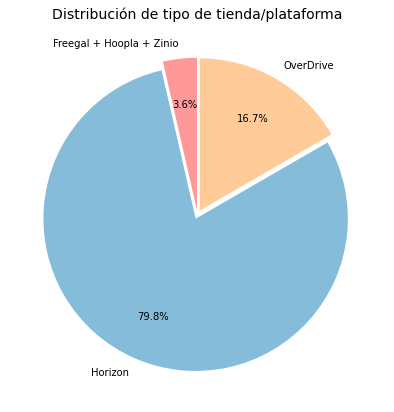

In [ ]:
pie, ax = plt.subplots(figsize=[10,7])
colors = ['#ff9999', '#84BCDA','#ffcc99','#ffcc99', "#c2c2f0"]
plt.pie(x=df_group['distribution'], autopct="%.1f%%", explode=[0.03]*3, startangle=90, labels=df_group['CheckoutType'], pctdistance=0.7, colors=colors)
plt.title("Distribución de tipo de tienda/plataforma", fontsize=14);

In [ ]:
df_total['UsageClass_'] = df_total['UsageClass'].astype('category').cat.codes
df_total['CheckoutType_'] = df_total['CheckoutType'].astype('category').cat.codes
df_total['MaterialType_'] = df_total['MaterialType'].astype('category').cat.codes
df_total['Title_'] = df_total['Title'].astype('category').cat.codes
df_total['Creator_'] = df_total['Creator'].astype('category').cat.codes
df_total['Subjects_'] = df_total['Subjects'].astype('category').cat.codes
df_total['Publisher_'] = df_total['Publisher'].astype('category').cat.codes
df_total['PublicationYear_'] = df_total['PublicationYear'].astype('category').cat.codes
df_total

,UsageClass,CheckoutType,MaterialType,CheckoutYear,CheckoutMonth,Checkouts,Title,Creator,Subjects,Publisher,PublicationYear,UsageClass_,CheckoutType_,MaterialType_,Title_,Creator_,Subjects_,Publisher_,PublicationYear_
0,Physical,Horizon,BOOK,2006,6,1,McGraw-Hill's dictionary of American slang and...,"Spears, Richard A.",English language United States Slang Dictionar...,"McGraw-Hill,",c2006.,1,2,3,720450,281781,223557,43143,11259
1,Physical,Horizon,BOOK,2006,6,1,"Emma, Lady Hamilton / Flora Fraser.","Fraser, Flora","Hamilton Emma Lady 1761 1815, Nelson Horatio N...","Knopf : Distributed by Random House,","1987, c1986.",1,2,3,328318,101170,308149,37730,2252
2,Physical,Horizon,BOOK,2006,6,2,Red midnight,NaN,"Survival Fiction, Emigration and immigration F...",NaN,NaN,1,2,3,902279,-1,669195,-1,-1
3,Physical,Horizon,BOOK,2006,6,1,Just the financial facts how to identify nugge...,NaN,Investments Information services,NaN,NaN,1,2,3,621392,-1,361151,-1,-1
4,Physical,Horizon,SOUNDCASS,2006,6,3,single shard,NaN,"Korea Fiction, Pottery Fiction",NaN,NaN,1,2,47,1438619,-1,387519,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34892618,Physical,Horizon,BOOK,2014,8,2,Girls to the front : the true story of the Rio...,"Marcus, Sara, 1977-","Riot grrrl movement United States History, Fem...","HarperPerennial,",c2010.,1,2,3,410490,193138,587095,30560,11393
34892619,Physical,Horizon,SOUNDDISC,2014,8,1,"Alfred, Lord Tennyson [sound recording].","Tennyson, Alfred Tennyson, Baron, 1809-1892",NaN,"Naxos AudioBooks,",p2009.,1,2,51,58372,295112,-1,47097,11905
34892620,Digital,OverDrive,AUDIOBOOK,2014,8,1,The Beach Club: A Novel (unabridged) (Unabridged),Elin Hilderbrand,"Fiction, Literature",Macmillan Audio,2013,0,3,2,1071830,87212,254414,41729,4376
34892621,Digital,OverDrive,EBOOK,2014,8,1,The Secret Adversary: Tommy and Tuppence Serie...,Agatha Christie,"Classic Literature, Fiction, Literature, Mystery",The Floating Press,2010,0,3,8,1136947,3608,140733,67177,4061


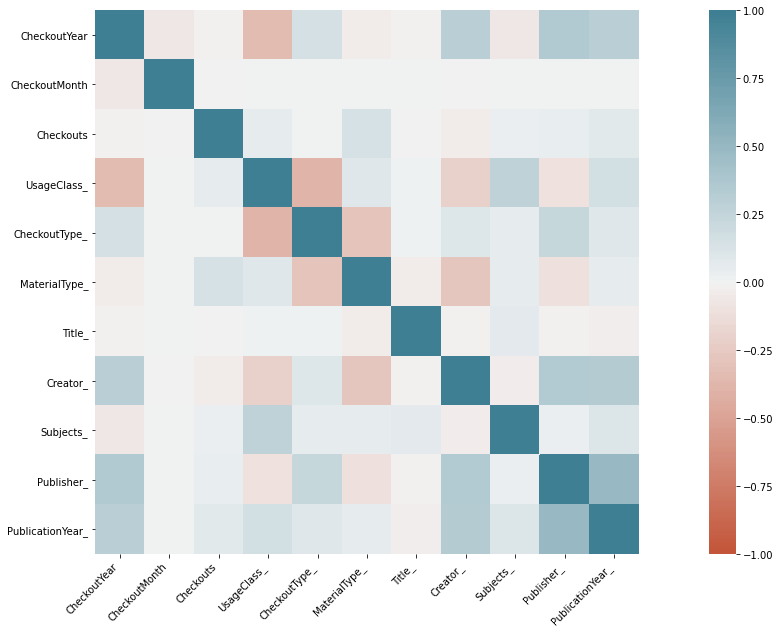

In [ ]:
columns_ = ['CheckoutYear','CheckoutMonth', 'Checkouts', 'UsageClass_', 'CheckoutType_',
       'MaterialType_', 'Title_', 'Creator_', 'Subjects_', 'Publisher_', 'PublicationYear_']
corr = df_total[columns_].corr()

plt.figure(figsize = (25, 10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

____
# Implementación
## Reservoir sampling

In [1]:
import pandas as pd
import numpy as np
import random as rd
import time

def ReservoirSampling(df, n_sample):
    start_time = time.time()
    df_ = df.to_numpy()
    df_rs = df_[:n_sample]
    indexs = [*range(0,n_sample)]
    
    for i in range(n_sample, len(df)):
        j = rd.randrange(i)
        if j < n_sample:
            df_rs[j] = df_[i]
            indexs[j] = i
            
    print("--- %s seconds ---" % (time.time() - start_time))
    return df_rs, indexs

n_sample = 340000
np_rs_final, indexs = ReservoirSampling(df_total, n_sample)

NameError: name 'df_total' is not defined

In [6]:
import pandas as pd
import numpy as np
import random as rd
import time

n_sample = 500_000
n_rows_read = 100_000
div = n_sample / n_rows_read

reader = pd.read_csv(CSV_DIR, chunksize = n_rows_read)
df_rs = []
columns = []
start_time = time.time()
indexs = [*range(0,n_sample)]

def ReservoirSamplingV2(df, index, num):    
    for itr in range(len(df)):
        i = (n_rows_read * index) + itr
        if index - div <= 0 and itr < num:
            df_rs.append(df[itr])
            indexs[i] = itr
        else:            
            j = rd.randrange(i)
            if j < n_sample:
                df_rs[j] = df[itr]
                indexs[j] = i

for index, rows in enumerate(reader):
    if index == 0:
        columns = rows.columns
        
    np_array = rows.to_numpy()
    ReservoirSamplingV2(np_array, index, (n_sample - len(df_rs)))
    if index % 50 == 0:
        print(index, "-", len(df_rs))

df_rs_final = pd.DataFrame(df_rs, columns = columns)
df_rs_final = df_rs_final.assign(Index = indexs)
df_rs_final
        
print("--- %s seconds ---" % (time.time() - start_time))
print(len(df_rs))
print(df_rs_final)

0 - 100000
50 - 500000
100 - 500000
150 - 500000
200 - 500000
250 - 500000
300 - 500000
--- 437.8200840950012 seconds ---
500000
       UsageClass CheckoutType MaterialType  CheckoutYear  CheckoutMonth  \
0        Physical      Horizon         BOOK          2007              1   
1         Digital    OverDrive    AUDIOBOOK          2008              6   
2        Physical      Horizon         BOOK          2005             12   
3        Physical      Horizon         BOOK          2008              2   
4        Physical      Horizon    SOUNDDISC          2006              2   
...           ...          ...          ...           ...            ...   
499995    Digital    OverDrive        EBOOK          2012              1   
499996   Physical      Horizon         BOOK          2006              5   
499997    Digital    OverDrive        EBOOK          2014              1   
499998   Physical      Horizon         BOOK          2009              7   
499999   Physical      Horizon     

In [ ]:
df_rs_final = pd.DataFrame(df_rs, columns = columns)
df_rs_final = df_rs_final.assign(Index = indexs)
df_rs_final

,UsageClass,CheckoutType,MaterialType,CheckoutYear,CheckoutMonth,Checkouts,Title,Creator,Subjects,Publisher,PublicationYear,Index
0,Physical,Horizon,SOUNDDISC,2011,5,3,And then nothing turned itself inside-out [sou...,Yo La Tengo (Musical group),Rock music 1991 2000,"Matador,",p2000.,10887330
1,Physical,Horizon,BOOK,2007,11,3,The man who knew infinity : a life of the geni...,"Kanigel, Robert","Ramanujan Aiyangar Srinivasa 1887 1920, Hardy ...","Washington Square Press,","[1992], c1991.",12711416
2,Physical,Horizon,VIDEOCASS,2007,1,3,Hyperspace,NaN,"Video recordings for the hearing impaired, Fea...",NaN,NaN,34667579
3,Digital,OverDrive,AUDIOBOOK,2014,1,1,The Patriots Club (Unabridged),Christopher Reich,"Fiction, Thriller",Books on Tape,2010,34029387
4,Physical,Horizon,BOOK,2011,2,1,Naruto Vol 6 The Forest of Death,NaN,"Comic books strips etc, Graphic novels, Ninja ...",NaN,NaN,4596575
...,...,...,...,...,...,...,...,...,...,...,...,...
339995,Physical,Horizon,BOOK,2007,10,1,Joy of cooking All about pies tarts,NaN,Pies,NaN,NaN,27657910
339996,Physical,Horizon,BOOK,2019,8,1,"Mongrels, bastards, orphans, and vagabonds : M...","Rodriguez, Gregory","Mexican Americans History, Mexican Americans E...","Pantheon Books,",[2007],1035331
339997,Physical,Horizon,BOOK,2016,3,24,Dinosaurs before dark / by Mary Pope Osborne ;...,"Osborne, Mary Pope","Dinosaurs Juvenile fiction, Time travel Juveni...","Random House,",c1992.,13519599
339998,Physical,Horizon,BOOK,2019,7,1,The future will be BS free / Will McIntosh.,"McIntosh, Will","Science fiction, Political corruption Juvenile...","Delacorte Press,",[2018],32806339


In [ ]:
max(df_rs_final["Index"])

34892421